# Embedding PCA Experiments

PCA can be used to interpret higher dimensional data by projecting the data into a lower dimensional space. This notebook looks at different ways to use PCA to analyze an embedding matrix. The embedding matrix comes from a colaborative filtering model trained on the [Movielens Data Set](http://files.grouplens.org/datasets/movielens/ml-latest-small.zip).

Two PCA analysis methods will be tested. One method analyzes the values in the matrix once it has been reduced in dimensionality. The other uses the transpose of the matrix to define principal components in lower dimensional space and analyzes the contribution of each matrix element to each principal component.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *
from fastai.column_data import *
from sklearn.decomposition import PCA

In [2]:
torch.cuda.set_device(1)
torch.cuda.is_available()

True

In [3]:
torch.backends.cudnn.enabled

True

In [4]:
path='data/ml-latest-small/'

In [5]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [6]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

In [8]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

In [9]:
top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')

In [10]:
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

In [11]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,110,260,296,318,356,480,527,589,593,608,1196,1198,1270,2571
userId,,,,,,,,,,,,,,,
15,2.0,3.0,5.0,5.0,2.0,1.0,3.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0
30,4.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,3.0
73,5.0,4.0,4.5,5.0,5.0,5.0,4.0,5.0,3.0,4.5,4.0,5.0,5.0,5.0,4.5
212,3.0,5.0,4.0,4.0,4.5,4.0,3.0,5.0,3.0,4.0,NaN,NaN,3.0,3.0,5.0
213,3.0,2.5,5.0,NaN,NaN,2.0,5.0,NaN,4.0,2.5,2.0,5.0,3.0,3.0,4.0
294,4.0,3.0,4.0,NaN,3.0,4.0,4.0,4.0,3.0,NaN,NaN,4.0,4.5,4.0,4.5
311,3.0,3.0,4.0,3.0,4.5,5.0,4.5,5.0,4.5,2.0,4.0,3.0,4.5,4.5,4.0
380,4.0,5.0,4.0,5.0,4.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,NaN,3.0,5.0
452,3.5,4.0,4.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,2.0


## Collaborative filtering

In [12]:
val_idxs = get_cv_idxs(len(ratings))
wd=2e-4
n_factors = 50

In [13]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')
learn = cf.get_learner(n_factors, val_idxs, 256, opt_fn=optim.Adam)

In [14]:
learn.fit(1e-2, 2, wds=wd, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      0.871979   0.858918  
    1      0.770357   0.77768                                                                                          
    2      0.621592   0.76243                                                                                          



[0.7624298059463501]

# PCA on Embedding Matrix

This method reduces the 50 weight values for each matrix into 3 dimensions and looks at what movies have the highest and lowest weight values in each dimension.

In [15]:
movie_names = movies.set_index('movieId')['title'].to_dict()
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False).index.values[:3000]
topMovieIdx = np.array([cf.item2idx[o] for o in topMovies])

In [16]:
m = learn.model
m.cuda();

In [17]:
movie_emb = to_np(m.i(V(topMovieIdx)))

In [18]:
pca = PCA(n_components=3)
emb_pca = pca.fit_transform(movie_emb)

For the three dimensions, we can look at which movies had the most positive or negative values in that dimension.

Dimension 1:

In [19]:
dim1 = emb_pca.T[0]
movie_comp = [(f, movie_names[i]) for f,i in zip(dim1, topMovies)]
sorted(movie_comp, key=itemgetter(0), reverse=True)[:20]

[(1.1554006, 'Godfather, The (1972)'),
 (1.0593711, 'Pulp Fiction (1994)'),
 (1.0132289, 'Fargo (1996)'),
 (0.9960791, 'Godfather: Part II, The (1974)'),
 (0.94477713, 'Casablanca (1942)'),
 (0.91130906, 'Usual Suspects, The (1995)'),
 (0.8722209, 'Chinatown (1974)'),
 (0.84513074, "Schindler's List (1993)"),
 (0.8281386, 'Goodfellas (1990)'),
 (0.82251316, 'Citizen Kane (1941)'),
 (0.79852194, 'Apocalypse Now (1979)'),
 (0.79614675, 'Memento (2000)'),
 (0.7902121,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (0.7787037, 'Taxi Driver (1976)'),
 (0.7659158, 'Maltese Falcon, The (1941)'),
 (0.753897, 'L.A. Confidential (1997)'),
 (0.74696094,
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)'),
 (0.7404483, 'American Beauty (1999)'),
 (0.73931783, 'Raging Bull (1980)'),
 (0.73448783, "One Flew Over the Cuckoo's Nest (1975)")]

In [20]:
sorted(movie_comp, key=itemgetter(0))[:20]

[(-0.9033074, 'Ace Ventura: When Nature Calls (1995)'),
 (-0.83738, 'Police Academy 4: Citizens on Patrol (1987)'),
 (-0.81039876, 'Police Academy 3: Back in Training (1986)'),
 (-0.8095879, 'Anaconda (1997)'),
 (-0.80080336, 'Waterworld (1995)'),
 (-0.7859083, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.7806431, 'Mission: Impossible II (2000)'),
 (-0.7803528, 'Home Alone 3 (1997)'),
 (-0.768391, 'Lost in Space (1998)'),
 (-0.7592606, 'Battlefield Earth (2000)'),
 (-0.7308889, 'Karate Kid, Part III, The (1989)'),
 (-0.7290135, 'Beverly Hills Cop III (1994)'),
 (-0.7180208, 'Armageddon (1998)'),
 (-0.70846826, 'Little Nicky (2000)'),
 (-0.6840218, 'Police Academy 2: Their First Assignment (1985)'),
 (-0.6819938, 'Coyote Ugly (2000)'),
 (-0.67515993, 'Batman Forever (1995)'),
 (-0.6734782, 'Nine Months (1995)'),
 (-0.66499865, 'Howard the Duck (1986)'),
 (-0.66185176, 'Sgt. Bilko (1996)')]

Dimension 2:

In [21]:
dim2 = emb_pca.T[1]
movie_comp = [(f, movie_names[i]) for f,i in zip(dim2, topMovies)]
sorted(movie_comp, key=itemgetter(0), reverse=True)[:20]

[(0.8882703, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (0.87536216,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (0.8481007, 'Lethal Weapon (1987)'),
 (0.8340088, 'Matrix, The (1999)'),
 (0.8315229, 'Spider-Man (2002)'),
 (0.8231629, 'Lord of the Rings: The Two Towers, The (2002)'),
 (0.8113451, 'Lord of the Rings: The Return of the King, The (2003)'),
 (0.80868894, 'Star Wars: Episode IV - A New Hope (1977)'),
 (0.80658114, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (0.7857233, 'X2: X-Men United (2003)'),
 (0.78136533, 'Forrest Gump (1994)'),
 (0.776591, 'Dark Knight, The (2008)'),
 (0.775737, 'Jurassic Park (1993)'),
 (0.7582671, 'X-Men (2000)'),
 (0.75164706, 'Good Will Hunting (1997)'),
 (0.7450126, 'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (0.7298025, 'Gladiator (2000)'),
 (0.7203911, 'Shrek (2001)'),
 (0.70720655, 'Shawshank Redemption, The (1994)'),
 (0.7055275, 'Braveheart (1995)')]

In [22]:
sorted(movie_comp, key=itemgetter(0))[:20]

[(-0.5313506, 'Manhattan (1979)'),
 (-0.5237905, 'Super Mario Bros. (1993)'),
 (-0.5085312, 'Vertigo (1958)'),
 (-0.5064167, 'Stepford Wives, The (1975)'),
 (-0.4987944, 'Deer Hunter, The (1978)'),
 (-0.49053213, 'Tank Girl (1995)'),
 (-0.48156077, 'Threesome (1994)'),
 (-0.481047, 'Doctor Zhivago (1965)'),
 (-0.46661198, 'Mission to Mars (2000)'),
 (-0.46411926, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.46332175, 'Avengers, The (1998)'),
 (-0.46303636, 'Flintstones, The (1994)'),
 (-0.45626915, 'Mulholland Drive (2001)'),
 (-0.45528242, 'What Ever Happened to Baby Jane? (1962)'),
 (-0.45449966, 'Mr. Wrong (1996)'),
 (-0.4539599, 'Cable Guy, The (1996)'),
 (-0.4519662, 'Heavenly Creatures (1994)'),
 (-0.45107085, '8 1/2 (8½) (1963)'),
 (-0.44127837, 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (-0.43356615, 'Catwoman (2004)')]

Dimension 3:

In [23]:
dim3 = emb_pca.T[2]
movie_comp = [(f, movie_names[i]) for f,i in zip(dim3, topMovies)]
sorted(movie_comp, key=itemgetter(0), reverse=True)[:20]

[(0.73364735, 'Scream (1996)'),
 (0.643948, 'True Lies (1994)'),
 (0.62560433, 'Happiness (1998)'),
 (0.55652034, 'Silence of the Lambs, The (1991)'),
 (0.5423419, 'Spaceballs (1987)'),
 (0.53503877, 'Clue (1985)'),
 (0.5208755, 'Happy Gilmore (1996)'),
 (0.5163022, 'Mallrats (1995)'),
 (0.50964355, 'American Pie (1999)'),
 (0.50923157, 'Scary Movie (2000)'),
 (0.5073256, 'Dumb & Dumber (Dumb and Dumber) (1994)'),
 (0.49935317, 'Naked Gun 33 1/3: The Final Insult (1994)'),
 (0.48914903, 'Office Space (1999)'),
 (0.47878355, 'Terminator 2: Judgment Day (1991)'),
 (0.47644255, "Prizzi's Honor (1985)"),
 (0.47447017, '2001: A Space Odyssey (1968)'),
 (0.4738153, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (0.47322214, 'Road Trip (2000)'),
 (0.46537513,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (0.44398147, 'Mars Attacks! (1996)')]

In [24]:
sorted(movie_comp, key=itemgetter(0))[:20]

[(-0.54417986, 'Bend It Like Beckham (2002)'),
 (-0.5180229, 'The Imitation Game (2014)'),
 (-0.49913406, 'Modern Times (1936)'),
 (-0.47707662,
  'Triplets of Belleville, The (Les triplettes de Belleville) (2003)'),
 (-0.4586951, 'Shawshank Redemption, The (1994)'),
 (-0.45373908, "Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)"),
 (-0.4535453, 'Black Swan (2010)'),
 (-0.44981053, 'Inside Out (2015)'),
 (-0.44137624, 'Few Good Men, A (1992)'),
 (-0.4375674, 'Talk to Her (Hable con Ella) (2002)'),
 (-0.43323833, 'Little Miss Sunshine (2006)'),
 (-0.43039948, 'Beautiful Mind, A (2001)'),
 (-0.4281406, 'Great Expectations (1998)'),
 (-0.42782876, 'Chicago (2002)'),
 (-0.42644793, 'Man on the Moon (1999)'),
 (-0.42131394, 'Super 8 (2011)'),
 (-0.41721845, 'Philadelphia (1993)'),
 (-0.41024774, 'Great Dictator, The (1940)'),
 (-0.40648887, 'Fantastic Mr. Fox (2009)'),
 (-0.4059386, 'Arsenic and Old Lace (1944)')]

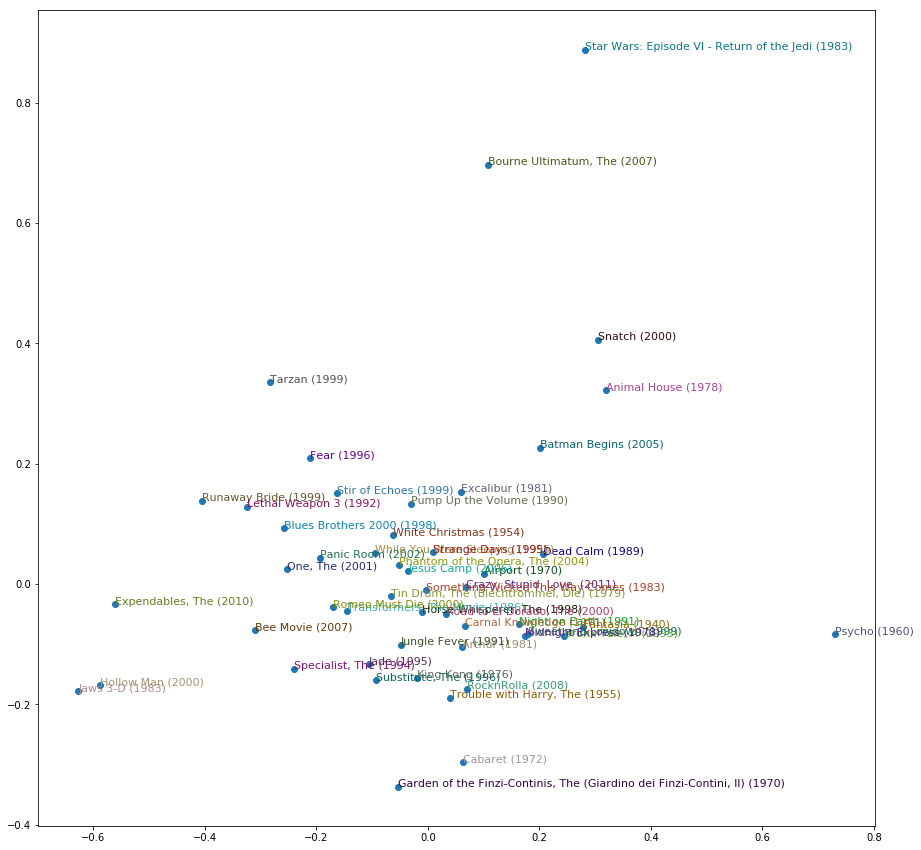

In [25]:
idxs = np.random.choice(len(topMovies), 50, replace=False)
X = dim1[idxs]
Y = dim2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[idxs], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

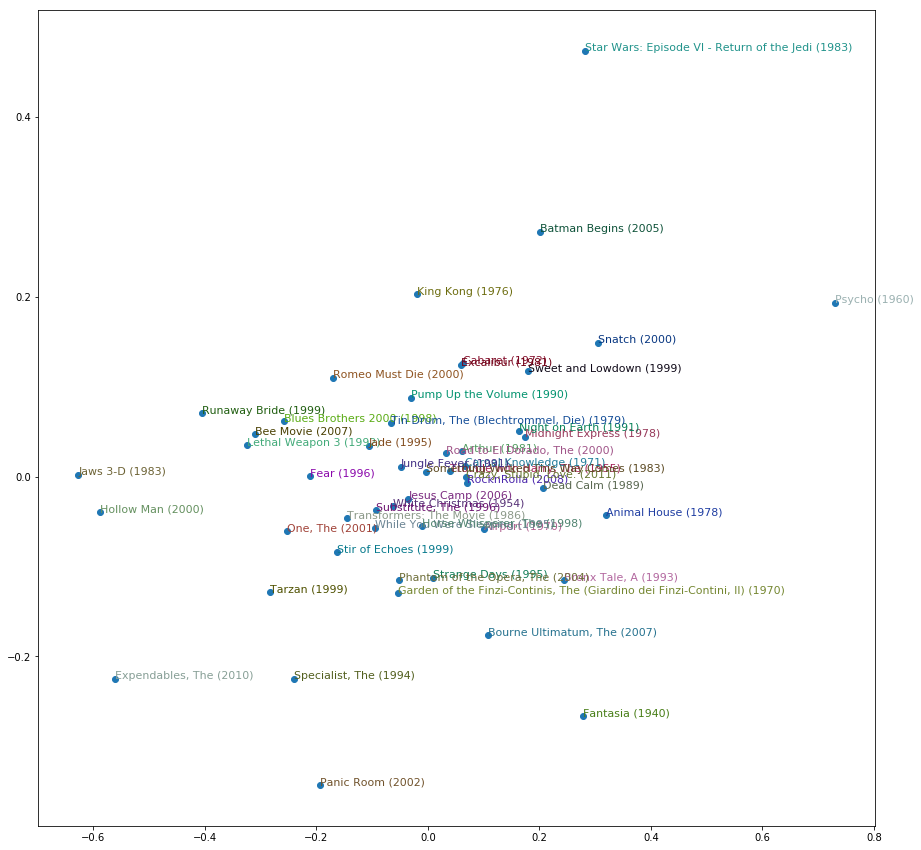

In [26]:
X = dim1[idxs]
Y = dim3[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[idxs], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

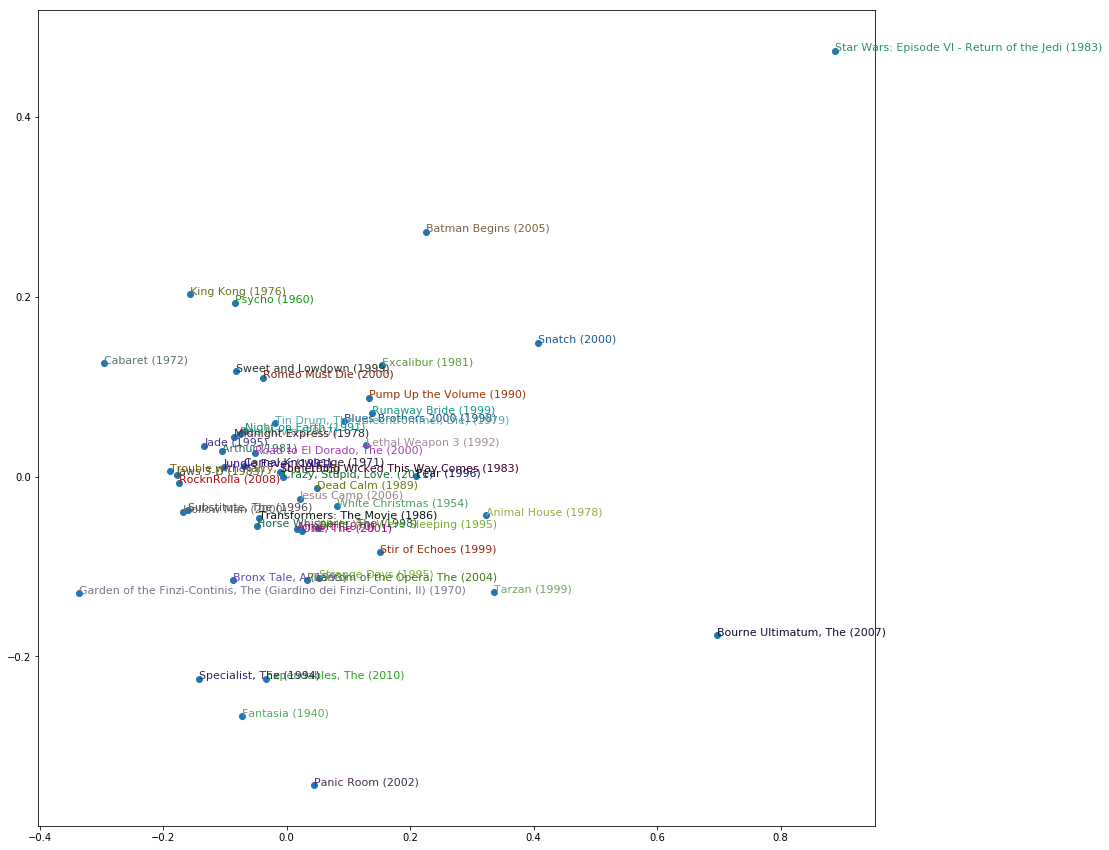

In [27]:
X = dim2[idxs]
Y = dim3[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[idxs], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

# PCA Components from Transpose of Embedding Matrix

This method fits a PCA function to the transpose of the embedding matrix and looks at the principal components of the model. This way we can see how each movie contributed to each principal component.

In [28]:
pca2 = PCA(n_components=3)
movie_pca = pca2.fit(movie_emb.T).components_

Dimension 1:

In [29]:
dim1_2 = movie_pca[0]
movie_comp = [(f, movie_names[i]) for f,i in zip(dim1_2, topMovies)]
sorted(movie_comp, key=itemgetter(0), reverse=True)[:20]

[(0.08130157, 'Godfather, The (1972)'),
 (0.07362553, 'Pulp Fiction (1994)'),
 (0.073031, 'Godfather: Part II, The (1974)'),
 (0.07140675, 'Fargo (1996)'),
 (0.06848831, 'Usual Suspects, The (1995)'),
 (0.0663863, 'Casablanca (1942)'),
 (0.06481296,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (0.06433061, "Schindler's List (1993)"),
 (0.060479667, 'Chinatown (1974)'),
 (0.059495945, 'Memento (2000)'),
 (0.05882394, 'Goodfellas (1990)'),
 (0.058379095, 'Shawshank Redemption, The (1994)'),
 (0.056740984, 'Citizen Kane (1941)'),
 (0.056054495, 'Fight Club (1999)'),
 (0.055306137, 'Apocalypse Now (1979)'),
 (0.054960124, 'L.A. Confidential (1997)'),
 (0.05477118, 'Taxi Driver (1976)'),
 (0.054274224, 'Raging Bull (1980)'),
 (0.0539009, 'American Beauty (1999)'),
 (0.052908335, 'Maltese Falcon, The (1941)')]

In [30]:
sorted(movie_comp, key=itemgetter(0))[:20]

[(-0.050570328, 'Ace Ventura: When Nature Calls (1995)'),
 (-0.049451012, 'Anaconda (1997)'),
 (-0.046953186, 'Police Academy 3: Back in Training (1986)'),
 (-0.046778332, 'Police Academy 4: Citizens on Patrol (1987)'),
 (-0.046010476, 'Battlefield Earth (2000)'),
 (-0.0457094, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.044739973, 'Home Alone 3 (1997)'),
 (-0.044072866, 'Waterworld (1995)'),
 (-0.042558976, 'Karate Kid, Part III, The (1989)'),
 (-0.042041108, 'Beverly Hills Cop III (1994)'),
 (-0.04148942, 'Mission: Impossible II (2000)'),
 (-0.040552054, 'Lost in Space (1998)'),
 (-0.040375337, 'Mission to Mars (2000)'),
 (-0.039613795, 'Howard the Duck (1986)'),
 (-0.038784124, 'Barb Wire (1996)'),
 (-0.03843693, 'Striptease (1996)'),
 (-0.03810519, 'Jack Frost (1998)'),
 (-0.037976157, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.03767213, 'Sgt. Bilko (1996)'),
 (-0.037418503, 'Batman Forever (1995)')]

Dimension 2:

In [31]:
dim2_2 = movie_pca[1]
movie_comp = [(f, movie_names[i]) for f,i in zip(dim2_2, topMovies)]
sorted(movie_comp, key=itemgetter(0), reverse=True)[:20]

[(0.05035874, 'Vertigo (1958)'),
 (0.049711883, 'Deer Hunter, The (1978)'),
 (0.047766812, 'Manhattan (1979)'),
 (0.045392074, 'Doctor Zhivago (1965)'),
 (0.042180434, 'Heavenly Creatures (1994)'),
 (0.04151491,
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)'),
 (0.040622998, 'Threesome (1994)'),
 (0.0405668, 'What Ever Happened to Baby Jane? (1962)'),
 (0.04040169, 'Mulholland Drive (2001)'),
 (0.038870286, '2001: A Space Odyssey (1968)'),
 (0.03817651, 'Super Mario Bros. (1993)'),
 (0.037846718, '8 1/2 (8½) (1963)'),
 (0.037529103, 'Room with a View, A (1986)'),
 (0.03703876, 'Stepford Wives, The (1975)'),
 (0.036605664, 'Paradise Lost: The Child Murders at Robin Hood Hills (1996)'),
 (0.036558058, 'Clockwork Orange, A (1971)'),
 (0.035868187, 'Bob Roberts (1992)'),
 (0.035695832, 'Tank Girl (1995)'),
 (0.035658933, 'Flirting With Disaster (1996)'),
 (0.03535304, 'Lost Highway (1997)')]

In [32]:
sorted(movie_comp, key=itemgetter(0))[:20]

[(-0.08217629, 'Lethal Weapon (1987)'),
 (-0.08157567, 'Spider-Man (2002)'),
 (-0.081443444, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (-0.08087812, 'X-Men (2000)'),
 (-0.078772664, 'X2: X-Men United (2003)'),
 (-0.07693447,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (-0.07410679, 'Jurassic Park (1993)'),
 (-0.0736468, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (-0.073485084, 'Matrix, The (1999)'),
 (-0.073375784, 'Armageddon (1998)'),
 (-0.07325646, 'Star Wars: Episode IV - A New Hope (1977)'),
 (-0.07306674, 'Shrek (2001)'),
 (-0.07229123, 'Lord of the Rings: The Two Towers, The (2002)'),
 (-0.071288005, 'Gladiator (2000)'),
 (-0.06970669, 'Forrest Gump (1994)'),
 (-0.06920618, 'Lord of the Rings: The Return of the King, The (2003)'),
 (-0.068859465, 'Independence Day (a.k.a. ID4) (1996)'),
 (-0.06740808, 'Braveheart (1995)'),
 (-0.06737184, 'Dark Knight, The (2008)'),
 (-0.06682939, 'Bourne Ultimatum, The (2007)

Dimension 3:

In [33]:
dim3_2 = movie_pca[2]
movie_comp = [(f, movie_names[i]) for f,i in zip(dim3_2, topMovies)]
sorted(movie_comp, key=itemgetter(0), reverse=True)[:20]

[(0.086327076, 'Scream (1996)'),
 (0.075806096, 'True Lies (1994)'),
 (0.07398299, 'Happiness (1998)'),
 (0.06577226, 'Silence of the Lambs, The (1991)'),
 (0.06363636, 'Spaceballs (1987)'),
 (0.063080356, 'Clue (1985)'),
 (0.06151722, 'Happy Gilmore (1996)'),
 (0.06108332, 'Mallrats (1995)'),
 (0.06024979, 'Scary Movie (2000)'),
 (0.059881996, 'American Pie (1999)'),
 (0.05934642, 'Dumb & Dumber (Dumb and Dumber) (1994)'),
 (0.059329197, 'Naked Gun 33 1/3: The Final Insult (1994)'),
 (0.05773804, 'Office Space (1999)'),
 (0.056747805, "Prizzi's Honor (1985)"),
 (0.055884488, 'Road Trip (2000)'),
 (0.05585506, '2001: A Space Odyssey (1968)'),
 (0.05568241, 'Terminator 2: Judgment Day (1991)'),
 (0.054525245, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (0.05384501,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (0.05334127, 'Mars Attacks! (1996)')]

In [34]:
sorted(movie_comp, key=itemgetter(0))[:20]

[(-0.06375142, 'Bend It Like Beckham (2002)'),
 (-0.06088362, 'The Imitation Game (2014)'),
 (-0.058162343, 'Modern Times (1936)'),
 (-0.05556479,
  'Triplets of Belleville, The (Les triplettes de Belleville) (2003)'),
 (-0.054606773, 'Shawshank Redemption, The (1994)'),
 (-0.053565696, "Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)"),
 (-0.052956916, 'Black Swan (2010)'),
 (-0.05228117, 'Few Good Men, A (1992)'),
 (-0.05220226, 'Inside Out (2015)'),
 (-0.051133603, 'Talk to Her (Hable con Ella) (2002)'),
 (-0.050919358, 'Beautiful Mind, A (2001)'),
 (-0.05033731, 'Little Miss Sunshine (2006)'),
 (-0.05010163, 'Man on the Moon (1999)'),
 (-0.049868762, 'Great Expectations (1998)'),
 (-0.049647544, 'Chicago (2002)'),
 (-0.04960915, 'Super 8 (2011)'),
 (-0.049174353, 'Philadelphia (1993)'),
 (-0.04751589, 'Great Dictator, The (1940)'),
 (-0.047503524, 'Arsenic and Old Lace (1944)'),
 (-0.047458727, 'Score, The (2001)')]

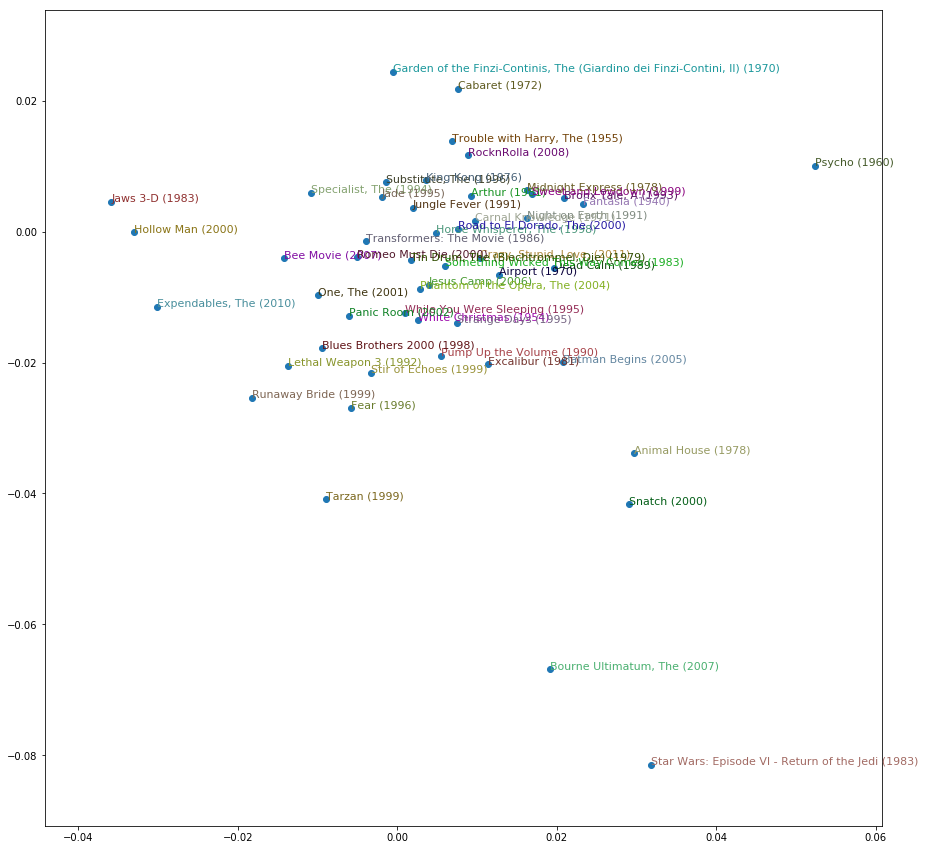

In [35]:
X = dim1_2[idxs]
Y = dim2_2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[idxs], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

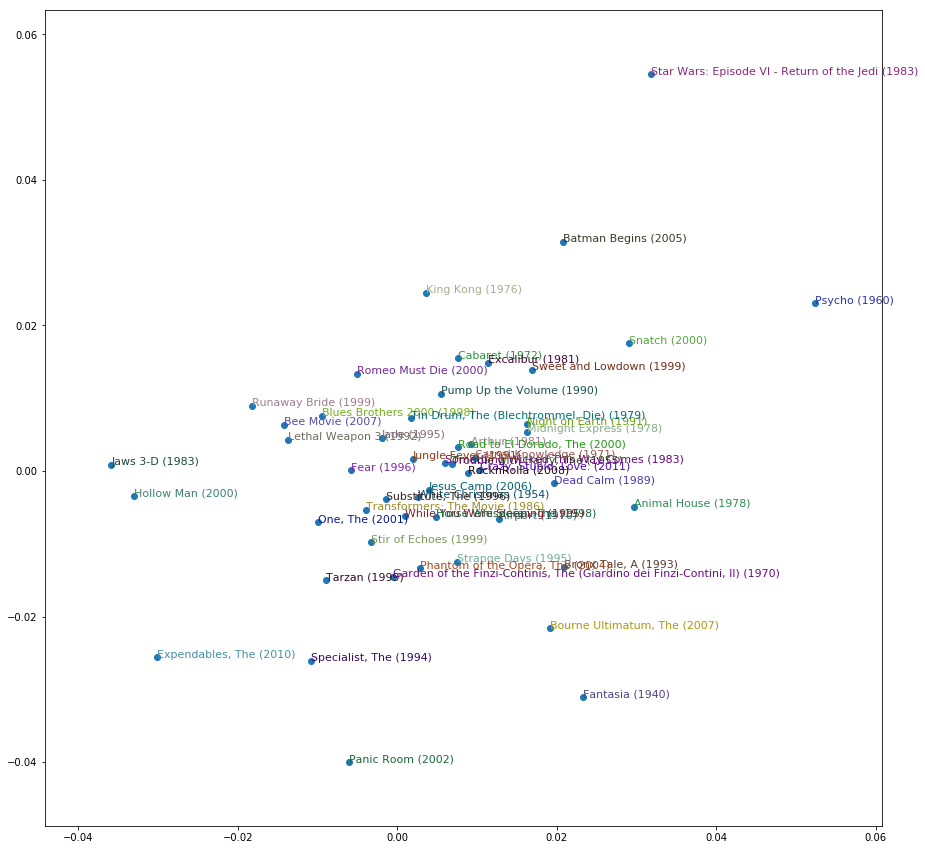

In [36]:
X = dim1_2[idxs]
Y = dim3_2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[idxs], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

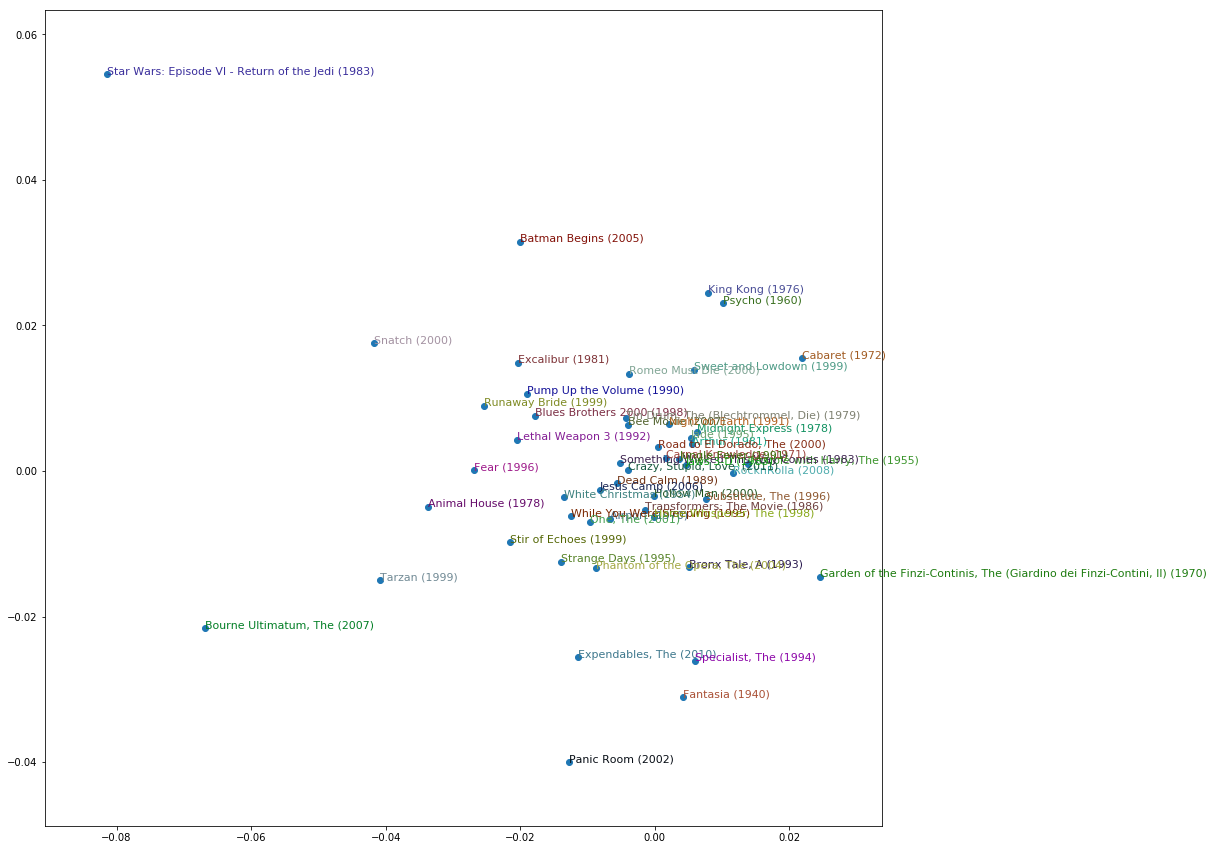

In [37]:
X = dim2_2[idxs]
Y = dim3_2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[idxs], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

# Conclusions

The two methods seem to produce very similar clusterings along the principal axes. 